# FIT5196  Assessment 3
#### Student Name: Hristina Todorovska
#### Student ID: 29193869

Date: 19/05/2019

Version: 1.0

Environment: Python 3.6.4 and Jupyter notebook

Libraries used:


In [1]:
import pandas as pd
import fiona 
import shapefile as shp
from shapely.geometry import Point, shape
from shapely.geometry.polygon import Polygon
import geopandas as gpd
import math
from datetime import datetime,timedelta

import numpy as np
import ast
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

# Task 1: Data Integration

Expected output:
```
COLUMN
ID| Address| Suburb |Price| Type |Date| Rooms| Bathroom| Car| LandSize| Age| Lattitude| Longtitude |train_station_id| distance_to_train_station| travel_min_to_CBD| over_priced | crime_A_average | crime_B_average | crime_C_average |
```

To integrate multiple datasets into one dataset, I will starting with reading all the datasets and recognise the connection between them.

In [2]:
df = pd.read_csv("29193869.csv")
house = df.copy()
house.head()

ID          Address  Rooms Type      Price        Date  Bathroom  \
0  ID208449822    3/3 Irving St      2    u   700000.0  27/11/2016       1.0   
1  ID769174153     23 Jacana St      3    h  1000000.0  27/11/2016       1.0   
2  ID189383754      101 Male St      3    h  1935000.0   3/06/2017       2.0   
3  ID176258151  11 Inverloch St      3    h  1330000.0  27/11/2016       2.0   
4  ID256217023    26 Collins St      3    h  1270000.0  19/11/2016       1.0   

   Car  Landsize   Age  Lattitude  Longtitude  
0  2.0       0.0  21.0  -37.85970   145.03180  
1  2.0     630.0  59.0  -37.88380   145.10200  
2  1.0     385.0  79.0  -37.91068   145.00394  
3  3.0     502.0  69.0  -37.74060   145.01550  
4  2.0     470.0  49.0  -37.85870   144.88710

In [3]:
print (house.shape) 

(720, 12)


### Suburb
- Find Suburbs based on the latitude longitude on the property.

In [4]:
shpFile = './vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp.shp'

In [5]:
vic = gpd.read_file(shpFile)
print("Shape of the dataframe: {}".format(vic.shape))
print("Projection of dataframe: {}".format(vic.crs))
vic.head() 

Shape of the dataframe: (2973, 13)
Projection of dataframe: {'proj': 'longlat', 'ellps': 'GRS80', 'no_defs': True}


LC_PLY_PID   DT_CREATE DT_RETIRE  LOC_PID  VIC_LOCALI VIC_LOCA_1 VIC_LOCA_2  \
0       6670  2011-08-31      None  VIC2615  2012-04-27       None  UNDERBOOL   
1       6671  2011-08-31      None  VIC1986  2012-04-27       None     NURRAN   
2       6672  2011-08-31      None  VIC2862  2012-04-27       None   WOORNDOO   
3       6673  2011-08-31      None   VIC734  2017-08-09       None   DEPTFORD   
4       6674  2011-08-31      None  VIC2900  2012-04-27       None      YANAC   

  VIC_LOCA_3 VIC_LOCA_4 VIC_LOCA_5 VIC_LOCA_6 VIC_LOCA_7  \
0       None       None          G       None          2   
1       None       None          G       None          2   
2       None       None          G       None          2   
3       None       None          G       None          2   
4       None       None          G       None          2   

                                            geometry  
0  POLYGON ((141.74552399 -35.07228701, 141.74552...  
1  POLYGON ((148.668767 -37.39571245, 148.6687620...  
2  POLYGON ((142.92287999 -37.97885997, 142.90449...  
3  POLYGON ((147.82335712 -37.66000897, 147.82312...  
4  POLYGON ((141.279783 -35.99858911, 141.2798853...

After reading the shp file we can see that the suburb is saved in VIC_LOCA_2 column.

For matching the points or the properties in which location/Suburb belong I am using ``coor_to_nbr`` method. This method is taken from : <br/>
https://gis.stackexchange.com/questions/244677/performing-spatial-join-match-points-from-dataframe-to-polygons-using-python <br/>
As and input Longitude, Latitude  and .``shp`` file. 

In [6]:
def coor_to_nbr(longit, lat, shape_file):
    mypoint = Point(longit,lat)  
    
    with fiona.open(shape_file) as shp:
        polygons = [poly for poly in shp]
    poly_idx = [i for i, poly in enumerate(polygons)
                if mypoint.within(shape(poly['geometry']))]
   
    if not poly_idx:
        return None
    else:
        # Take first polygon that overlaps since may overlap with several if on border
        match = polygons[poly_idx[0]]
        return match['properties']['VIC_LOCA_2']
    
#test the method
s = coor_to_nbr(145.03180, -37.85970, shpFile)
print(s)

MALVERN


In the next part I will apply the method for all rows to find the Suburbs.<br/>
Input: Longtitude, Lattitude and shpFile

In [7]:
house['Suburb'] = house.apply(lambda row:coor_to_nbr(row['Longtitude'],row['Lattitude'],shpFile), axis=1)

In [8]:
house.head()

ID          Address  Rooms Type      Price        Date  Bathroom  \
0  ID208449822    3/3 Irving St      2    u   700000.0  27/11/2016       1.0   
1  ID769174153     23 Jacana St      3    h  1000000.0  27/11/2016       1.0   
2  ID189383754      101 Male St      3    h  1935000.0   3/06/2017       2.0   
3  ID176258151  11 Inverloch St      3    h  1330000.0  27/11/2016       2.0   
4  ID256217023    26 Collins St      3    h  1270000.0  19/11/2016       1.0   

   Car  Landsize   Age  Lattitude  Longtitude        Suburb  
0  2.0       0.0  21.0  -37.85970   145.03180       MALVERN  
1  2.0     630.0  59.0  -37.88380   145.10200     CHADSTONE  
2  1.0     385.0  79.0  -37.91068   145.00394      BRIGHTON  
3  3.0     502.0  69.0  -37.74060   145.01550       PRESTON  
4  2.0     470.0  49.0  -37.85870   144.88710  WILLIAMSTOWN

In [9]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 13 columns):
ID            720 non-null object
Address       720 non-null object
Rooms         720 non-null int64
Type          720 non-null object
Price         720 non-null float64
Date          720 non-null object
Bathroom      720 non-null float64
Car           720 non-null float64
Landsize      720 non-null float64
Age           720 non-null float64
Lattitude     720 non-null float64
Longtitude    720 non-null float64
Suburb        720 non-null object
dtypes: float64(7), int64(1), object(5)
memory usage: 73.2+ KB


After I found the Suburbs I will continue to work on finding the closet train station to the property.

I will read all the files inside gtfs, and I am saving the data in dataframe named same as the file.

In [10]:
numFiles = [1, 2, 3, 4, 5, 6, 7, 8, 10, 11]

agency = pd.DataFrame()
calendar = pd.DataFrame()
calendar_dates = pd.DataFrame()
routes = pd.DataFrame()
shapes = pd.DataFrame()
stop_times= pd.DataFrame()
stops = pd.DataFrame()
trips = pd.DataFrame()

files = ["agency", "calendar", "calendar_dates", "routes", "shapes", "stop_times", "stops", "trips"]
for i in numFiles:
    for file in files:
        x = pd.read_csv("./gtfs/"+str(i)+"/"+file+".txt")
        columnNames = list(x.columns.values)
        vars()[file] = pd.concat([vars()[file], x])[columnNames]

After I read all the files I will remove duplicate rows.

In [11]:
calendar = calendar.drop_duplicates()
agency = agency.drop_duplicates()
calendar_dates = calendar_dates.drop_duplicates()
routes = routes.drop_duplicates()
shapes = shapes.drop_duplicates()
stop_times = stop_times.drop_duplicates()
stops = stops.drop_duplicates()
trips = trips.drop_duplicates()

To find the closest train station to the property that has a direct trip to the
Southern Cross Railway Station, first find the information about Southern Cross train station.

In [12]:
stops[stops['stop_name'].str.contains("Southern Cross Railway") ]

stop_id                                          stop_name   stop_lat  \
7      20043    Southern Cross Railway Station (Melbourne City) -37.818334   
210    22180    Southern Cross Railway Station (Melbourne City) -37.817936   
308    18187  122-Southern Cross Railway Station/Spencer St ... -37.818801   
312    18194  122-Southern Cross Railway Station/Spencer St ... -37.818776   

       stop_lon  
7    144.952525  
210  144.951411  
308  144.953966  
312  144.954069

We have 2 stations id named as Southern Cross Railway Station (Melbourne City). One is vLine and the other is Metro, we will use 20043 and 22180 to check the requirements. The last two are tram stations.

In [13]:
SCstopId = [20043, 22180]

### Closest train station to the property (staton, average travel time, distance)
the closest station to each property is the staton that has a direct trip to the SC station departing from 7 to 9:30am


* From calender dataframe I will filter all the rows that have 1 for Monday to Friday. <br/>
`` 1 `` service is available this day <br/>
``0`` service is not available <br/>
I will need all the service Id that have 1 from Monday to Friday. <br/>
I am returng ``servce_id`` in ``calendarWeekday`` DataFrame. (All services that are available from Mon to Fri)


In [14]:
calendarWeekday = calendar[(calendar['monday']==1)&(calendar['tuesday']==1)&(calendar['wednesday']==1)&(calendar['thursday']==1) &(calendar['friday']==1)][['service_id']].copy()
calendarWeekday.head()

service_id
6          T0
13       T0_1
16       T0_2
20       T0_3
11         T0

* In this part I am filtering ``trips`` DataFrame with ``calendarWeekday['trip_id']`` 

In [15]:
tmpTrips = trips[trips['service_id'].isin(calendarWeekday['service_id'])].copy()

In [16]:
tmpTrips.head()

route_id service_id                    trip_id           shape_id  \
0  1-V08-G-mjp-1         T0  1051.T0.1-V08-G-mjp-1.1.H  1-V08-G-mjp-1.1.H   
1  1-V08-G-mjp-1         T0  1052.T0.1-V08-G-mjp-1.2.H  1-V08-G-mjp-1.2.H   
2  1-V08-G-mjp-1         T0  1053.T0.1-V08-G-mjp-1.2.H  1-V08-G-mjp-1.2.H   
3  1-V08-G-mjp-1         T0  1522.T0.1-V08-G-mjp-1.4.R  1-V08-G-mjp-1.4.R   
4  1-V08-G-mjp-1         T0  1523.T0.1-V08-G-mjp-1.5.R  1-V08-G-mjp-1.5.R   

  trip_headsign  direction_id  
0     Melbourne             0  
1     Melbourne             0  
2     Melbourne             0  
3    Bairnsdale             1  
4    Bairnsdale             1

* ``tmpTrips`` Dataframe contans all the ``trip_id`` which have servce from Monday to Friday, because I need the stop_id I will return all stop_times for the trips from ``tmpTrips``. <br/>
I am fltering ``tmpTrips`` on ``stop_times`` 

In [17]:
tmpStopTimes = stop_times[stop_times['trip_id'].isin(tmpTrips['trip_id'])].copy()

* Now we have all the stops avalable from Monday to Friday. <br/>
We need only the stops that pass through Southern Cross station. Here I will filter only the the trips which include Southern Cross.

In [18]:
tripSCId = tmpStopTimes[tmpStopTimes['stop_id'].isin(SCstopId)]['trip_id']
stationsMF = tmpStopTimes[tmpStopTimes['trip_id'].isin(tripSCId)].copy()

In [19]:
stationsMF.head()

trip_id arrival_time departure_time  stop_id  \
578  1051.T0.1-V08-G-mjp-1.1.H     06:08:00       06:08:00    20291   
579  1051.T0.1-V08-G-mjp-1.1.H     06:42:00       06:42:00    20346   
580  1051.T0.1-V08-G-mjp-1.1.H     06:55:00       06:57:00    20341   
581  1051.T0.1-V08-G-mjp-1.1.H     07:16:00       07:16:00    20339   
582  1051.T0.1-V08-G-mjp-1.1.H     07:32:00       07:34:00    20351   

     stop_sequence  stop_headsign  pickup_type  drop_off_type  \
578              1            NaN            0              0   
579              2            NaN            0              0   
580              3            NaN            0              0   
581              4            NaN            0              0   
582              5            NaN            0              0   

     shape_dist_traveled  
578             0.000000  
579         52720.840026  
580         68786.649688  
581         94514.728171  
582        116895.210301

In [20]:
stationsMF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45546 entries, 578 to 468757
Data columns (total 9 columns):
trip_id                45546 non-null object
arrival_time           45546 non-null object
departure_time         45546 non-null object
stop_id                45546 non-null int64
stop_sequence          45546 non-null int64
stop_headsign          0 non-null float64
pickup_type            45546 non-null int64
drop_off_type          45546 non-null int64
shape_dist_traveled    45546 non-null float64
dtypes: float64(2), int64(4), object(3)
memory usage: 3.5+ MB


* ``stationsMF`` is DataFrame which contains all stop_times which service is available from Monday to Friday and pass through Souther Cross station. <br/>
``stop_sequence`` is column whch give as information about the sequence of the stops. The statons which have direct trip to Southern Cross stations have stop_sequence  less then the stop_sequence for Southern Cross Station. <br/>



In [21]:
#creating Dictionary {"trip_id" : "stop_sequence"} where stop_sequence is stop_sequence for Southern Cross station
stop_times_sc_sequence = stationsMF[stationsMF['stop_id'].isin(SCstopId)][['trip_id', 'stop_sequence']].copy()
dict_sc_sequence = dict(zip(stop_times_sc_sequence['trip_id'], stop_times_sc_sequence['stop_sequence']))

In [22]:
stationsMF['sc_stop_sequence'] = stationsMF['trip_id'].apply(lambda x: dict_sc_sequence[x])

* Here I create new column ``sc_stop_sequence`` which give me information about the stop sequence for Southern Cross. <br/>
Because I need to calculate the average time of the trip later I need the arrival time on Southern Cross Station. So I will do the same step as the stop_sequence for the arrival_time.

In [23]:
#creating Dictionary {"trip_id" : "arrival_time"} where arrival_time is arrival_time on Southern Cross station
stop_times_sc_arrival_time = stationsMF[stationsMF['stop_id'].isin(SCstopId)][['trip_id', 'arrival_time']].copy()
dict_sc_arrival_time = dict(zip(stop_times_sc_arrival_time['trip_id'], stop_times_sc_arrival_time['arrival_time']))

In [24]:
stationsMF['sc_arrival_time'] = stationsMF['trip_id'].apply(lambda x: dict_sc_arrival_time[x])

In [25]:
stationsMF.head()

trip_id arrival_time departure_time  stop_id  \
578  1051.T0.1-V08-G-mjp-1.1.H     06:08:00       06:08:00    20291   
579  1051.T0.1-V08-G-mjp-1.1.H     06:42:00       06:42:00    20346   
580  1051.T0.1-V08-G-mjp-1.1.H     06:55:00       06:57:00    20341   
581  1051.T0.1-V08-G-mjp-1.1.H     07:16:00       07:16:00    20339   
582  1051.T0.1-V08-G-mjp-1.1.H     07:32:00       07:34:00    20351   

     stop_sequence  stop_headsign  pickup_type  drop_off_type  \
578              1            NaN            0              0   
579              2            NaN            0              0   
580              3            NaN            0              0   
581              4            NaN            0              0   
582              5            NaN            0              0   

     shape_dist_traveled  sc_stop_sequence sc_arrival_time  
578             0.000000                23        09:57:00  
579         52720.840026                23        09:57:00  
580         68786.649688                23        09:57:00  
581         94514.728171                23        09:57:00  
582        116895.210301                23        09:57:00

* Now I will filter the departure time between between 7:00 to 9:30 am. <br/>
 ``parseTime`` is method with input string which format the time into "%H:%M:%S" <br/>
  First  I will parse departure_time and then return only stop_times where departure time is between  7:00 to 9:30 am.

In [26]:
def parseTime(arrdep):
    try:
        d = datetime.strptime(arrdep,"%H:%M:%S")
        
    except ValueError:
        hours, rest = arrdep.split(':',1)
        if int(hours) > 23:
            hours = int(hours) % 24
            t = str(hours)+':'+rest
       
            d = datetime.strptime(t,"%H:%M:%S")
            d += timedelta(1)
            
    return d 

In [27]:
stationsMF['departure_time'] = stationsMF['departure_time'].apply(parseTime)

In [28]:
start = datetime.strptime('06:59:59', '%H:%M:%S')
end = datetime.strptime('09:30:01', '%H:%M:%S')

In [29]:
filterStationsMF = stationsMF[(~stationsMF['stop_id'].isin(SCstopId))&(start < stationsMF['departure_time'])&(stationsMF['departure_time'] < end)&(stationsMF['stop_sequence'] < stationsMF['sc_stop_sequence'])].copy()

``filterStationsMF`` is the final Fltered Dataframe, now I will return all station_id which has direct trip to Souther Cross station from Monday to Friday.

In [30]:
stations = list(set(filterStationsMF['stop_id']))
len(stations)


285

I found 285 stations that have direct trip to Southern Cross from Monday to Friday between 7 to 9:30 am.

* After I found all the stations that are going directly to Southern Crosss, I am going to find the closest station to the property that is going directly to Southern Cross and the distance between the property and the station. <br/>
https://engineering.upside.com/a-beginners-guide-to-optimizing-pandas-code-for-speed-c09ef2c6a4d6  I used this resource to calculate the distance. <br/>
The method ``distance`` calculate the distance between two points. Input Origin (Longtitude, Lattitude), Destination (Longtitude, Lattitude) and statioId. <br/>
The output of this method is the distance in meter and the stationId.

In [31]:
def distance(origin, destination, stopId):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6378 # Earth’s radius km 
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    d = radius * c * 1000 # in m

    return dict(zip(stopId,d))

In [32]:
stopDirect = stops[stops['stop_id'].isin(stations)]

I am creating columns ``train_station_id`` and  ``distance_to_train_stat`` and applyng the method ``distance`` based on the property location and all the stations that have direct trip to Southern Cross station.

In [33]:
house['train_station_id'] = house.apply(lambda x: min(distance((x['Lattitude'],x['Longtitude']),(stopDirect['stop_lat'], stopDirect['stop_lon']),stopDirect['stop_id']).items(), key = lambda r: r[1])[0],axis=1)
house['distance_to_train_stat'] = house.apply(lambda x: min(distance((x['Lattitude'],x['Longtitude']),(stopDirect['stop_lat'], stopDirect['stop_lon']),stopDirect['stop_id']).items(), key = lambda r: r[1])[1],axis=1)

house.head()

ID          Address  Rooms Type      Price        Date  Bathroom  \
0  ID208449822    3/3 Irving St      2    u   700000.0  27/11/2016       1.0   
1  ID769174153     23 Jacana St      3    h  1000000.0  27/11/2016       1.0   
2  ID189383754      101 Male St      3    h  1935000.0   3/06/2017       2.0   
3  ID176258151  11 Inverloch St      3    h  1330000.0  27/11/2016       2.0   
4  ID256217023    26 Collins St      3    h  1270000.0  19/11/2016       1.0   

   Car  Landsize   Age  Lattitude  Longtitude        Suburb  train_station_id  \
0  2.0       0.0  21.0  -37.85970   145.03180       MALVERN             19944   
1  2.0     630.0  59.0  -37.88380   145.10200     CHADSTONE             19917   
2  1.0     385.0  79.0  -37.91068   145.00394      BRIGHTON             19952   
3  3.0     502.0  69.0  -37.74060   145.01550       PRESTON             20012   
4  2.0     470.0  49.0  -37.85870   144.88710  WILLIAMSTOWN             19993   

   distance_to_train_stat  
0              762.015301  
1             2202.258004  
2              655.409099  
3             1335.821817  
4              230.436788

* Next I am going to calculate the average travel time (minutes) from the closest train station
(regional/metropolitan) that has a direct trip to the “Southern
Cross Railway Station” on weekdays (i.e. Monday-Friday)
departing between 7 to 9:30 am.

``stationsMF`` Dataframe is flter stop_times Dataframe (I filter above) that contains only the stations that have direct trip the “Southern
Cross Railway Station” on weekdays (i.e. Monday-Friday)
departing between 7 to 9:30 am.

In [34]:
stationsMF.head()

trip_id arrival_time      departure_time  stop_id  \
578  1051.T0.1-V08-G-mjp-1.1.H     06:08:00 1900-01-01 06:08:00    20291   
579  1051.T0.1-V08-G-mjp-1.1.H     06:42:00 1900-01-01 06:42:00    20346   
580  1051.T0.1-V08-G-mjp-1.1.H     06:55:00 1900-01-01 06:57:00    20341   
581  1051.T0.1-V08-G-mjp-1.1.H     07:16:00 1900-01-01 07:16:00    20339   
582  1051.T0.1-V08-G-mjp-1.1.H     07:32:00 1900-01-01 07:34:00    20351   

     stop_sequence  stop_headsign  pickup_type  drop_off_type  \
578              1            NaN            0              0   
579              2            NaN            0              0   
580              3            NaN            0              0   
581              4            NaN            0              0   
582              5            NaN            0              0   

     shape_dist_traveled  sc_stop_sequence sc_arrival_time  
578             0.000000                23        09:57:00  
579         52720.840026                23        09:57:00  
580         68786.649688                23        09:57:00  
581         94514.728171                23        09:57:00  
582        116895.210301                23        09:57:00

Abve I create colum ``sc_arrival_time`` which give us the arriva time to Southern Cross Staton for the specifc trip. Now I wil parse the time using the method ``parseTime``

In [35]:
filterStationsMF['sc_arrival_time'] = filterStationsMF['sc_arrival_time'].apply(parseTime)

In [36]:
filterStationsMF.head()

trip_id arrival_time      departure_time  stop_id  \
581  1051.T0.1-V08-G-mjp-1.1.H     07:16:00 1900-01-01 07:16:00    20339   
582  1051.T0.1-V08-G-mjp-1.1.H     07:32:00 1900-01-01 07:34:00    20351   
583  1051.T0.1-V08-G-mjp-1.1.H     07:45:00 1900-01-01 07:45:00    20330   
584  1051.T0.1-V08-G-mjp-1.1.H     07:57:00 1900-01-01 07:57:00    20328   
585  1051.T0.1-V08-G-mjp-1.1.H     08:16:00 1900-01-01 08:16:00    20357   

     stop_sequence  stop_headsign  pickup_type  drop_off_type  \
581              4            NaN            0              0   
582              5            NaN            0              0   
583              6            NaN            0              0   
584              7            NaN            0              0   
585             10            NaN            0              0   

     shape_dist_traveled  sc_stop_sequence     sc_arrival_time  
581         94514.728171                23 1900-01-01 09:57:00  
582        116895.210301                23 1900-01-01 09:57:00  
583        130530.089787                23 1900-01-01 09:57:00  
584        145000.117101                23 1900-01-01 09:57:00  
585        175519.536474                23 1900-01-01 09:57:00

Next I will calculate the travel time. I am creating method ``calculateTravelTime`` with input departure, arrival tme and for output is the time in minutes.

In [37]:
def calculateTravelTime(departure, arrival):
    timeTravel =  ((arrival - departure).dt.total_seconds())/60
    
    return timeTravel

I am aplying ``calculateTravelTime`` for each row in the filterStationsMF DataFrame .

In [38]:
filterStationsMF['time_travel'] = calculateTravelTime(filterStationsMF['departure_time'],filterStationsMF['sc_arrival_time'])

In [39]:
filterStationsMF.head()

trip_id arrival_time      departure_time  stop_id  \
581  1051.T0.1-V08-G-mjp-1.1.H     07:16:00 1900-01-01 07:16:00    20339   
582  1051.T0.1-V08-G-mjp-1.1.H     07:32:00 1900-01-01 07:34:00    20351   
583  1051.T0.1-V08-G-mjp-1.1.H     07:45:00 1900-01-01 07:45:00    20330   
584  1051.T0.1-V08-G-mjp-1.1.H     07:57:00 1900-01-01 07:57:00    20328   
585  1051.T0.1-V08-G-mjp-1.1.H     08:16:00 1900-01-01 08:16:00    20357   

     stop_sequence  stop_headsign  pickup_type  drop_off_type  \
581              4            NaN            0              0   
582              5            NaN            0              0   
583              6            NaN            0              0   
584              7            NaN            0              0   
585             10            NaN            0              0   

     shape_dist_traveled  sc_stop_sequence     sc_arrival_time  time_travel  
581         94514.728171                23 1900-01-01 09:57:00        161.0  
582        116895.210301                23 1900-01-01 09:57:00        143.0  
583        130530.089787                23 1900-01-01 09:57:00        132.0  
584        145000.117101                23 1900-01-01 09:57:00        120.0  
585        175519.536474                23 1900-01-01 09:57:00        101.0

Now after I have all the times for each trip to the Souther Cross Staton( Mon - Fri , between 7 - 9 :30am), I am going t calculate the averageTime for each station. I create method ``averageTime`` with input statioId and filterStationsMF(Data Frame) and the output is the average time. Then I am going to apply this method to stops DataFrame.

In [40]:
def averageTime(stId, filterStationsMF):
    
    timeMin = filterStationsMF[filterStationsMF['stop_id']==stId]['time_travel']
    avgTime = sum(timeMin)/len(timeMin)
    return avgTime

In [41]:
stops['travel_min_to_CBD'] = stops['stop_id'].apply(lambda x: averageTime(x, filterStationsMF) if x in stations else 0)

After I calculate the average Travel Time for all the statins , I will copy the time from stops Dataframe to the property house DataFrame. <br/>


In [42]:
house['travel_min_to_CBD'] = house['train_station_id'].apply(lambda x: stops[stops['stop_id']==x]['travel_min_to_CBD'].values[0])

In [43]:
house.head()

ID          Address  Rooms Type      Price        Date  Bathroom  \
0  ID208449822    3/3 Irving St      2    u   700000.0  27/11/2016       1.0   
1  ID769174153     23 Jacana St      3    h  1000000.0  27/11/2016       1.0   
2  ID189383754      101 Male St      3    h  1935000.0   3/06/2017       2.0   
3  ID176258151  11 Inverloch St      3    h  1330000.0  27/11/2016       2.0   
4  ID256217023    26 Collins St      3    h  1270000.0  19/11/2016       1.0   

   Car  Landsize   Age  Lattitude  Longtitude        Suburb  train_station_id  \
0  2.0       0.0  21.0  -37.85970   145.03180       MALVERN             19944   
1  2.0     630.0  59.0  -37.88380   145.10200     CHADSTONE             19917   
2  1.0     385.0  79.0  -37.91068   145.00394      BRIGHTON             19952   
3  3.0     502.0  69.0  -37.74060   145.01550       PRESTON             20012   
4  2.0     470.0  49.0  -37.85870   144.88710  WILLIAMSTOWN             19993   

   distance_to_train_stat  travel_min_to_CBD  
0              762.015301          20.800000  
1             2202.258004          29.354839  
2              655.409099          24.500000  
3             1335.821817          28.300000  
4              230.436788          20.857143

### Calculate Crime

In this part I am going to calcuate the average Crime in the Local gvernment Area for each of the property. Because I have Suburbs for the property I will calcuate the local government area usng the ``councils.txt`` file.

In [44]:
d = {}
with open("councils.txt") as f:
    for line in f:
        key, value = line.strip().split(':', 1)
        d[key.strip()] = ast.literal_eval(value.strip())
        
print(d['BANYULE'])


['Abbotsford', 'Airport West', 'Albert Park', 'Alphington']


 I am returning the data (the local government area ) into dictionary where the key is the name of the the local government area  and the value is list of Suburbs for this local government area. </br>
 Because in the prperty Dataframe Suburbs column is uppercase I will convert all the values in the councils dictionary to be uppercase.

In [45]:
d.update({k.upper(): [element.upper() for element in v] for k, v in d.items()})
print(d['BANYULE'])

['ABBOTSFORD', 'AIRPORT WEST', 'ALBERT PARK', 'ALPHINGTON']


Next I am ging to read the crime DataFrame.

In [46]:
df = pd.read_excel (r'crimebylocationdatatable-yearending31march2016.xlsx', sheet_name='Table 1')
df.head(25)

Unnamed: 0                                         Unnamed: 1  \
0          NaN                                                NaN   
1          NaN                                                NaN   
2          NaN                                                NaN   
3          NaN                                                NaN   
4          NaN                                                NaN   
5          NaN                                                NaN   
6          NaN                                                NaN   
7          NaN                                                NaN   
8          NaN                                                NaN   
9          NaN  Table 1. Number of offences by geographic area...   
10         NaN                                                NaN   
11         NaN                                                NaN   
12         NaN                                                NaN   
13         NaN                                                NaN   
14         NaN                                                NaN   
15         NaN                                                NaN   
16         NaN                                                NaN   
17         NaN                                                NaN   
18         NaN                         Apr - Mar reference period   
19         NaN                                               2012   
20         NaN                                               2012   
21         NaN                                               2012   
22         NaN                                               2012   
23         NaN                                               2012   
24         NaN                                               2012   

            Unnamed: 2           Unnamed: 3             Unnamed: 4  \
0                  NaN                  NaN                    NaN   
1                  NaN                  NaN                    NaN   
2                  NaN                  NaN                    NaN   
3                  NaN                  NaN                    NaN   
4                  NaN                  NaN                    NaN   
5                  NaN                  NaN                    NaN   
6                  NaN                  NaN                    NaN   
7                  NaN                  NaN                    NaN   
8                  NaN                  NaN                    NaN   
9                  NaN                  NaN                    NaN   
10                 NaN                  NaN                    NaN   
11                 NaN                  NaN                    NaN   
12                 NaN                  NaN                    NaN   
13                 NaN                  NaN                    NaN   
14                 NaN                  NaN                    NaN   
15                 NaN                  NaN                    NaN   
16                 NaN                  NaN                    NaN   
17                 NaN                  NaN                    NaN   
18       Police Region  Police Service Area  Local Government Area   
19  1 North West Metro              BANYULE                BANYULE   
20  1 North West Metro              BANYULE                BANYULE   
21  1 North West Metro              BANYULE                BANYULE   
22  1 North West Metro              BANYULE                BANYULE   
23  1 North West Metro              BANYULE                BANYULE   
24  1 North West Metro              BANYULE                BANYULE   

                     Unnamed: 5                          Unnamed: 6  \
0                           NaN                                 NaN   
1                           NaN                                 NaN   
2                           NaN                                 NaN   
3                           NaN                                 NaN   
4                           NaN  

We can see that the first 17 collumns ar all NaN values so,  I will use row 18 to be column, and the data to be readed from row 19.

In [47]:
crime = df.copy()
crime.head()

Unnamed: 0 Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4 Unnamed: 5  \
0         NaN        NaN        NaN        NaN        NaN        NaN   
1         NaN        NaN        NaN        NaN        NaN        NaN   
2         NaN        NaN        NaN        NaN        NaN        NaN   
3         NaN        NaN        NaN        NaN        NaN        NaN   
4         NaN        NaN        NaN        NaN        NaN        NaN   

  Unnamed: 6 Unnamed: 7 Unnamed: 8 Unnamed: 9  
0        NaN        NaN        NaN        NaN  
1        NaN        NaN        NaN        NaN  
2        NaN        NaN        NaN        NaN  
3        NaN        NaN        NaN        NaN  
4        NaN        NaN        NaN        NaN

In [48]:
new_header = crime.iloc[18] #grab the 18th row for the header
crime = crime[19:] #take the data after the header row
crime.columns = new_header #set the header row as the df header

In [49]:
del crime[crime.columns[0]]

In [50]:
crime = crime.reset_index(drop=True)

In [51]:
crime.head() 

18 Apr - Mar reference period       Police Region Police Service Area  \
0                        2012  1 North West Metro             BANYULE   
1                        2012  1 North West Metro             BANYULE   
2                        2012  1 North West Metro             BANYULE   
3                        2012  1 North West Metro             BANYULE   
4                        2012  1 North West Metro             BANYULE   

18 Local Government Area         CSA Offence Division  \
0                BANYULE  A Crimes against the person   
1                BANYULE  A Crimes against the person   
2                BANYULE  A Crimes against the person   
3                BANYULE  A Crimes against the person   
4                BANYULE  A Crimes against the person   

18             CSA Offence Subdivision Offence Count LGA ERP Victorian ERP  
0    A10 Homicide and related offences             4  123600       5632521  
1     A20 Assault and related offences           568  123600       5632521  
2                  A30 Sexual offences           132  123600       5632521  
3   A40 Abduction and related offences            12  123600       5632521  
4                          A50 Robbery            46  123600       5632521

For calculating the annual average Crime I create method ``averageCrime`` with input (area, crime, crimeType, year) <br/>
``area`` is the Local Government Area <br/>
``crime`` id the crime DataFrame <br/>
``crimeType``  is a string A|B|C for the type of the crime that we want to calculate<br/>
``year`` is list of years for which we want to calculate the crime <br/>
e.g. ``averageCrime('BANYULE',crime,'A',[2012, 2013])`` <br/>
The output of the method is the average of `` Offence Count``

In [52]:
def averageCrime(area, crime, crimeType, year):
    offence = crime[(crime['Local Government Area']==area)&(crime['CSA Offence Division'].str.startswith(crimeType))&(crime['Apr - Mar reference period'].isin(year))]['Offence Count']
    
    if len(offence) > 0:
        #avgCrime = sum(offence)/len(offence)
        avgCrime = sum(offence)/3
    else:
        avgCrime = '-1'
    return avgCrime

In [53]:
#test the method
averageCrime('BANYULE',crime,'A',[2012, 2013])

724.3333333333334

In [54]:
houseProp = house.copy()

Create list of all properties suburbs.

In [55]:
suburbs = list(set(house['Suburb']))
len(suburbs)

192

In this part I am going to find the local government area for each Suburb from the property Dataset. <br/>
``getLocalGovernmentArea`` is method whch return the local government area for the specific Suburb. <br/>
Input: Suburb and councils dictionary <br/>
Output: the local government area 

In [56]:
def getLocalGovernmentArea(suburb, d):
    area = 'WARRNAMBOOL'
    for key, value in d.items():
        if suburb in value or suburb == key:
            return key
    return area

I am creating Area column where I wll fill all the local government area  for each of the prperties.

In [57]:
house['Area'] = house['Suburb'].apply(lambda x:getLocalGovernmentArea(x,d))

In [58]:
house.head()

ID          Address  Rooms Type      Price        Date  Bathroom  \
0  ID208449822    3/3 Irving St      2    u   700000.0  27/11/2016       1.0   
1  ID769174153     23 Jacana St      3    h  1000000.0  27/11/2016       1.0   
2  ID189383754      101 Male St      3    h  1935000.0   3/06/2017       2.0   
3  ID176258151  11 Inverloch St      3    h  1330000.0  27/11/2016       2.0   
4  ID256217023    26 Collins St      3    h  1270000.0  19/11/2016       1.0   

   Car  Landsize   Age  Lattitude  Longtitude        Suburb  train_station_id  \
0  2.0       0.0  21.0  -37.85970   145.03180       MALVERN             19944   
1  2.0     630.0  59.0  -37.88380   145.10200     CHADSTONE             19917   
2  1.0     385.0  79.0  -37.91068   145.00394      BRIGHTON             19952   
3  3.0     502.0  69.0  -37.74060   145.01550       PRESTON             20012   
4  2.0     470.0  49.0  -37.85870   144.88710  WILLIAMSTOWN             19993   

   distance_to_train_stat  travel_min_to_CBD        Area  
0              762.015301          20.800000     BAW BAW  
1             2202.258004          29.354839      MELTON  
2              655.409099          24.500000        HUME  
3             1335.821817          28.300000  BOROONDARA  
4              230.436788          20.857143   MAROONDAH

In [59]:
crime.head()

18 Apr - Mar reference period       Police Region Police Service Area  \
0                        2012  1 North West Metro             BANYULE   
1                        2012  1 North West Metro             BANYULE   
2                        2012  1 North West Metro             BANYULE   
3                        2012  1 North West Metro             BANYULE   
4                        2012  1 North West Metro             BANYULE   

18 Local Government Area         CSA Offence Division  \
0                BANYULE  A Crimes against the person   
1                BANYULE  A Crimes against the person   
2                BANYULE  A Crimes against the person   
3                BANYULE  A Crimes against the person   
4                BANYULE  A Crimes against the person   

18             CSA Offence Subdivision Offence Count LGA ERP Victorian ERP  
0    A10 Homicide and related offences             4  123600       5632521  
1     A20 Assault and related offences           568  123600       5632521  
2                  A30 Sexual offences           132  123600       5632521  
3   A40 Abduction and related offences            12  123600       5632521  
4                          A50 Robbery            46  123600       5632521

Because in the crime dataframe the reference Period is Apr - Mar, I will create aditional column Year of Sale

``getYears(dateSold) `` is method with input Date of Sold, and Output: List of three years for which I will calculate the average crime.

In [60]:
import datetime
def getYears(dateSold):

    dateFormated = datetime.datetime.strptime(dateSold, "%d/%m/%Y")
    year = dateFormated.year
    
    y = [year-3, year-2, year-1]
    return y


In [61]:
getYears('27/11/2013')

[2010, 2011, 2012]

In [62]:
house['Year'] = house['Date'].apply(lambda x: getYears(x))

In [63]:
house.head()

ID          Address  Rooms Type      Price        Date  Bathroom  \
0  ID208449822    3/3 Irving St      2    u   700000.0  27/11/2016       1.0   
1  ID769174153     23 Jacana St      3    h  1000000.0  27/11/2016       1.0   
2  ID189383754      101 Male St      3    h  1935000.0   3/06/2017       2.0   
3  ID176258151  11 Inverloch St      3    h  1330000.0  27/11/2016       2.0   
4  ID256217023    26 Collins St      3    h  1270000.0  19/11/2016       1.0   

   Car  Landsize   Age  Lattitude  Longtitude        Suburb  train_station_id  \
0  2.0       0.0  21.0  -37.85970   145.03180       MALVERN             19944   
1  2.0     630.0  59.0  -37.88380   145.10200     CHADSTONE             19917   
2  1.0     385.0  79.0  -37.91068   145.00394      BRIGHTON             19952   
3  3.0     502.0  69.0  -37.74060   145.01550       PRESTON             20012   
4  2.0     470.0  49.0  -37.85870   144.88710  WILLIAMSTOWN             19993   

   distance_to_train_stat  travel_min_to_CBD        Area                Year  
0              762.015301          20.800000     BAW BAW  [2013, 2014, 2015]  
1             2202.258004          29.354839      MELTON  [2013, 2014, 2015]  
2              655.409099          24.500000        HUME  [2014, 2015, 2016]  
3             1335.821817          28.300000  BOROONDARA  [2013, 2014, 2015]  
4              230.436788          20.857143   MAROONDAH  [2013, 2014, 2015]

#### Crime A

I have defined the methds, now I will apply the calculation for all three types of crime.

In [64]:
house['crime_A_average'] = house.apply(lambda x: averageCrime(x['Area'],crime,'A',x['Year']),axis=1)

In [65]:
house.head()

ID          Address  Rooms Type      Price        Date  Bathroom  \
0  ID208449822    3/3 Irving St      2    u   700000.0  27/11/2016       1.0   
1  ID769174153     23 Jacana St      3    h  1000000.0  27/11/2016       1.0   
2  ID189383754      101 Male St      3    h  1935000.0   3/06/2017       2.0   
3  ID176258151  11 Inverloch St      3    h  1330000.0  27/11/2016       2.0   
4  ID256217023    26 Collins St      3    h  1270000.0  19/11/2016       1.0   

   Car  Landsize   Age  Lattitude  Longtitude        Suburb  train_station_id  \
0  2.0       0.0  21.0  -37.85970   145.03180       MALVERN             19944   
1  2.0     630.0  59.0  -37.88380   145.10200     CHADSTONE             19917   
2  1.0     385.0  79.0  -37.91068   145.00394      BRIGHTON             19952   
3  3.0     502.0  69.0  -37.74060   145.01550       PRESTON             20012   
4  2.0     470.0  49.0  -37.85870   144.88710  WILLIAMSTOWN             19993   

   distance_to_train_stat  travel_min_to_CBD        Area                Year  \
0              762.015301          20.800000     BAW BAW  [2013, 2014, 2015]   
1             2202.258004          29.354839      MELTON  [2013, 2014, 2015]   
2              655.409099          24.500000        HUME  [2014, 2015, 2016]   
3             1335.821817          28.300000  BOROONDARA  [2013, 2014, 2015]   
4              230.436788          20.857143   MAROONDAH  [2013, 2014, 2015]   

   crime_A_average  
0       610.000000  
1      1540.666667  
2      2897.333333  
3       659.000000  
4      1002.666667

#### Crime B

In [66]:
house['crime_B_average'] = house.apply(lambda x: averageCrime(x['Area'],crime,'B',x['Year']),axis=1)

#### Crime C

In [67]:
house['crime_C_average'] = house.apply(lambda x: averageCrime(x['Area'],crime,'C',x['Year']),axis=1)

In [68]:
house.head()

ID          Address  Rooms Type      Price        Date  Bathroom  \
0  ID208449822    3/3 Irving St      2    u   700000.0  27/11/2016       1.0   
1  ID769174153     23 Jacana St      3    h  1000000.0  27/11/2016       1.0   
2  ID189383754      101 Male St      3    h  1935000.0   3/06/2017       2.0   
3  ID176258151  11 Inverloch St      3    h  1330000.0  27/11/2016       2.0   
4  ID256217023    26 Collins St      3    h  1270000.0  19/11/2016       1.0   

   Car  Landsize   Age  ...  Longtitude        Suburb train_station_id  \
0  2.0       0.0  21.0  ...   145.03180       MALVERN            19944   
1  2.0     630.0  59.0  ...   145.10200     CHADSTONE            19917   
2  1.0     385.0  79.0  ...   145.00394      BRIGHTON            19952   
3  3.0     502.0  69.0  ...   145.01550       PRESTON            20012   
4  2.0     470.0  49.0  ...   144.88710  WILLIAMSTOWN            19993   

   distance_to_train_stat  travel_min_to_CBD        Area                Year  \
0              762.015301          20.800000     BAW BAW  [2013, 2014, 2015]   
1             2202.258004          29.354839      MELTON  [2013, 2014, 2015]   
2              655.409099          24.500000        HUME  [2014, 2015, 2016]   
3             1335.821817          28.300000  BOROONDARA  [2013, 2014, 2015]   
4              230.436788          20.857143   MAROONDAH  [2013, 2014, 2015]   

  crime_A_average  crime_B_average  crime_C_average  
0      610.000000      1743.666667       228.000000  
1     1540.666667      6062.333333       477.666667  
2     2897.333333     11243.000000       942.000000  
3      659.000000      5219.333333       338.333333  
4     1002.666667      4068.000000       328.333333  

[5 rows x 21 columns]

In [69]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 21 columns):
ID                        720 non-null object
Address                   720 non-null object
Rooms                     720 non-null int64
Type                      720 non-null object
Price                     720 non-null float64
Date                      720 non-null object
Bathroom                  720 non-null float64
Car                       720 non-null float64
Landsize                  720 non-null float64
Age                       720 non-null float64
Lattitude                 720 non-null float64
Longtitude                720 non-null float64
Suburb                    720 non-null object
train_station_id          720 non-null int64
distance_to_train_stat    720 non-null float64
travel_min_to_CBD         720 non-null float64
Area                      720 non-null object
Year                      720 non-null object
crime_A_average           720 non-null float64
crime_B_avera

### over_priced?

the price of the
property is higher than the median price of the similar properties
(with respect to bedrooms, bathrooms, parking_space, and
property_type attributes) in the same suburb on the year of
selling <br/>
`` |Rooms | Bathroom | Car | Type | Suburb | ``

In [70]:
house[house['Suburb'] == 'BRIGHTON']

ID            Address  Rooms Type      Price        Date  \
2    ID189383754        101 Male St      3    h  1935000.0   3/06/2017   
169  ID362951436    2/26 Pearson St      2    u   536000.0   3/12/2016   
175  ID973549036      1/76 Whyte St      2    t  1055000.0  20/05/2017   
177  ID897308792     17 McCallum St      4    h  3695000.0   3/12/2016   
215  ID958733966       24b Munro St      3    h  1302500.0   6/08/2016   
219  ID786770479  4/14 Brickwood St      2    u   858000.0  18/03/2017   
248  ID990364528     3/61 Martin St      3    u   880000.0  22/05/2016   
268  ID623614098          3 Rose St      2    t  1470000.0  29/04/2017   
328  ID472789825        10 Whyte St      4    h  2385000.0  27/05/2017   
504  ID308616489      18 Rooding St      3    h  1635000.0   3/09/2016   
671  ID212357587          17 New St      3    h  1900000.0   6/08/2016   

     Bathroom  Car  Landsize   Age  ...  Longtitude    Suburb  \
2         2.0  1.0     385.0  79.0  ...   145.00394  BRIGHTON   
169       1.0  2.0       0.0  49.0  ...   145.00430  BRIGHTON   
175       1.0  2.0     211.0  49.0  ...   144.99990  BRIGHTON   
177       3.0  2.0     836.0  59.0  ...   144.98980  BRIGHTON   
215       2.0  2.0       0.0  26.0  ...   144.99420  BRIGHTON   
219       1.0  1.0     107.0  69.0  ...   144.99820  BRIGHTON   
248       1.0  1.0     138.0  54.0  ...   144.99570  BRIGHTON   
268       1.0  1.0     238.0  14.0  ...   145.00480  BRIGHTON   
328       3.0  2.0     373.0  39.0  ...   144.99920  BRIGHTON   
504       1.0  2.0     366.0  99.0  ...   145.00010  BRIGHTON   
671       0.0  0.0       0.0  26.0  ...   144.99350  BRIGHTON   

    train_station_id  distance_to_train_stat  travel_min_to_CBD  Area  \
2              19952              655.409099               24.5  HUME   
169            19952              387.385285               24.5  HUME   
175            19951              725.484427               26.5  HUME   
177            19951             1060.983811               26.5  HUME   
215            19951              246.166923               26.5  HUME   
219            19953              533.669091               23.5  HUME   
248            19953              747.904996               23.5  HUME   
268            19953              208.437539               23.5  HUME   
328            19950              905.482452               28.5  HUME   
504            19952              251.114288               24.5  HUME   
671            19950              554.656766               28.5  HUME   

                   Year crime_A_average  crime_B_average  crime_C_average  
2    [2014, 2015, 2016]     2897.333333     11243.000000            942.0  
169  [2013, 2014, 2015]     2744.333333     10289.666667            780.0  
175  [2014, 2015, 2016]     2897.333333     11243.000000            942.0  
177  [2013, 2014, 2015]     2744.333333     10289.666667            780.0  
215  [2013, 2014, 2015]     2744.333333     10289.666667            780.0  
219  [2014, 2015, 2016]     2897.333333     11243.000000            942.0  
248  [2013, 2014, 2015]     2744.333333     10289.666667            780.0  
268  [2014, 2015, 2016]     2897.333333     11243.000000            942.0  
328  [2014, 2015, 2016]     2897.333333     11243.000000            942.0  
504  [2013, 2014, 2015]     2744.333333     10289.666667            780.0  
671  [2013, 2014, 2015]     2744.333333     10289.666667            780.0  

[11 rows x 21 columns]

I create method ``similarProperties`` which return the prices of all the properties that are simmilar. <br/>
To be simmilar properties, the property should have same number of rooms, to be same type, same umber of bathroom , same numbar of car parking and to be n the same Suburb.<br/>
As Input: (rooms, htype, bathroom, car, suburb,year, house) 
``rooms`` number <br/>
``htype`` string [u, t, h] <br/>
``bathroom`` number <br/>
``car`` number <br/>
``suburb`` string <br/>
``year`` number <br/>
``house`` Datagrame <br/>
Output: list with the prices of the simmilar prperties

In [71]:
def similarProperties(rooms, htype, bathroom, car, suburb,year, house):
    price = house[(house['Rooms'] == rooms) & (house['Type'] == htype) & (house['Bathroom'] == bathroom) & (house['Car'] == car) & (house['Suburb'] == suburb) &(house['Year Sold'] == year)]['Price']
    return price

In [72]:
house['Year Sold'] = house['Date'].apply(lambda x: datetime.datetime.strptime(x, "%d/%m/%Y").year)

In [73]:
house.head()

ID          Address  Rooms Type      Price        Date  Bathroom  \
0  ID208449822    3/3 Irving St      2    u   700000.0  27/11/2016       1.0   
1  ID769174153     23 Jacana St      3    h  1000000.0  27/11/2016       1.0   
2  ID189383754      101 Male St      3    h  1935000.0   3/06/2017       2.0   
3  ID176258151  11 Inverloch St      3    h  1330000.0  27/11/2016       2.0   
4  ID256217023    26 Collins St      3    h  1270000.0  19/11/2016       1.0   

   Car  Landsize   Age  ...        Suburb  train_station_id  \
0  2.0       0.0  21.0  ...       MALVERN             19944   
1  2.0     630.0  59.0  ...     CHADSTONE             19917   
2  1.0     385.0  79.0  ...      BRIGHTON             19952   
3  3.0     502.0  69.0  ...       PRESTON             20012   
4  2.0     470.0  49.0  ...  WILLIAMSTOWN             19993   

  distance_to_train_stat  travel_min_to_CBD        Area                Year  \
0             762.015301          20.800000     BAW BAW  [2013, 2014, 2015]   
1            2202.258004          29.354839      MELTON  [2013, 2014, 2015]   
2             655.409099          24.500000        HUME  [2014, 2015, 2016]   
3            1335.821817          28.300000  BOROONDARA  [2013, 2014, 2015]   
4             230.436788          20.857143   MAROONDAH  [2013, 2014, 2015]   

  crime_A_average crime_B_average  crime_C_average  Year Sold  
0      610.000000     1743.666667       228.000000       2016  
1     1540.666667     6062.333333       477.666667       2016  
2     2897.333333    11243.000000       942.000000       2017  
3      659.000000     5219.333333       338.333333       2016  
4     1002.666667     4068.000000       328.333333       2016  

[5 rows x 22 columns]

In [74]:
house[house['Suburb']=='WILLIAMSTOWN']

ID          Address  Rooms Type      Price        Date  \
4    ID256217023    26 Collins St      3    h  1270000.0  19/11/2016   
324  ID256217023    26 Collins St      3    h  1270000.0  19/11/2016   
357  ID957712563    19 MacLean St      4    h  1300000.0  27/06/2016   
406  ID173480935  12/53 Morris St      2    u   550000.0  22/04/2017   
683  ID622566159     45 Albert St      2    h   769000.0  18/06/2016   
719  ID256217023    26 Collins St      3    h  1270000.0  19/11/2016   

     Bathroom  Car  Landsize   Age  ...        Suburb  train_station_id  \
4         1.0  2.0     470.0  49.0  ...  WILLIAMSTOWN             19993   
324       1.0  2.0     470.0  49.0  ...  WILLIAMSTOWN             19993   
357       2.0  2.0     369.0  39.0  ...  WILLIAMSTOWN             19992   
406       1.0  2.0       0.0  29.0  ...  WILLIAMSTOWN             19991   
683       1.0  1.0     265.0  49.0  ...  WILLIAMSTOWN             19993   
719       1.0  2.0     470.0  49.0  ...  WILLIAMSTOWN             19993   

    distance_to_train_stat  travel_min_to_CBD       Area                Year  \
4               230.436788          20.857143  MAROONDAH  [2013, 2014, 2015]   
324             230.436788          20.857143  MAROONDAH  [2013, 2014, 2015]   
357             822.492310          21.857143  MAROONDAH  [2013, 2014, 2015]   
406              93.117561          23.857143  MAROONDAH  [2014, 2015, 2016]   
683             583.273734          20.857143  MAROONDAH  [2013, 2014, 2015]   
719             230.436788          20.857143  MAROONDAH  [2013, 2014, 2015]   

    crime_A_average crime_B_average  crime_C_average  Year Sold  
4       1002.666667     4068.000000       328.333333       2016  
324     1002.666667     4068.000000       328.333333       2016  
357     1002.666667     4068.000000       328.333333       2016  
406     1064.666667     4200.666667       432.666667       2017  
683     1002.666667     4068.000000       328.333333       2016  
719     1002.666667     4068.000000       328.333333       2016  

[6 rows x 22 columns]

In [75]:
#test the method
list(similarProperties(2,'u',1,2.0,'WILLIAMSTOWN',2017, house))

[550000.0]

I am applying the method to the property (house) Dataframe ad I am returnng the prices of the simmilar properties in new column similar_prop_price

In [76]:
house['similar_prop_price'] = house.apply(lambda x: list(similarProperties(x['Rooms'],x['Type'], x['Bathroom'], x['Car'], x['Suburb'],x['Year Sold'], house)),axis=1)

In [77]:
house.head()

ID          Address  Rooms Type      Price        Date  Bathroom  \
0  ID208449822    3/3 Irving St      2    u   700000.0  27/11/2016       1.0   
1  ID769174153     23 Jacana St      3    h  1000000.0  27/11/2016       1.0   
2  ID189383754      101 Male St      3    h  1935000.0   3/06/2017       2.0   
3  ID176258151  11 Inverloch St      3    h  1330000.0  27/11/2016       2.0   
4  ID256217023    26 Collins St      3    h  1270000.0  19/11/2016       1.0   

   Car  Landsize   Age  ...  train_station_id  distance_to_train_stat  \
0  2.0       0.0  21.0  ...             19944              762.015301   
1  2.0     630.0  59.0  ...             19917             2202.258004   
2  1.0     385.0  79.0  ...             19952              655.409099   
3  3.0     502.0  69.0  ...             20012             1335.821817   
4  2.0     470.0  49.0  ...             19993              230.436788   

  travel_min_to_CBD        Area                Year  crime_A_average  \
0         20.800000     BAW BAW  [2013, 2014, 2015]       610.000000   
1         29.354839      MELTON  [2013, 2014, 2015]      1540.666667   
2         24.500000        HUME  [2014, 2015, 2016]      2897.333333   
3         28.300000  BOROONDARA  [2013, 2014, 2015]       659.000000   
4         20.857143   MAROONDAH  [2013, 2014, 2015]      1002.666667   

  crime_B_average crime_C_average  Year Sold  \
0     1743.666667      228.000000       2016   
1     6062.333333      477.666667       2016   
2    11243.000000      942.000000       2017   
3     5219.333333      338.333333       2016   
4     4068.000000      328.333333       2016   

                  similar_prop_price  
0                         [700000.0]  
1                        [1000000.0]  
2                        [1935000.0]  
3                        [1330000.0]  
4  [1270000.0, 1270000.0, 1270000.0]  

[5 rows x 23 columns]

Next I need to find if is overpriced or no, to do that I am checing the median price in the method ``medanPos`` this method has input of ist wth all the priceswith simmilar properties and the price that we need to check if is overpriced or not.
First I am sorting the prices of the similar prperties, then I am am finding the median price. <br/>
If the price that I am checking is greather then the median I am returning 1 (True Overprced), otherwise I am returning 0 (false Not Overpriced)

In [78]:
def medanPos(data, price):
    n = len(data)
    x = sorted(data)
    
    if n % 2 >0 :
        m = int((n+1)/2)
        median = x[m-1]
    else:
        m1 = int(n/2)
        m2 = m1 + 1
        median = (x[m1-1] + x[m2-1])/2
        
    if price> median:
        return 1
    else:
        return 0

I am applyng the method on the house DataFrame and returning the output in column over_priced? 

In [79]:
house['over_priced?'] = house.apply(lambda x:medanPos(x['similar_prop_price'], x['Price']),axis=1)

In [80]:
house.head()

ID          Address  Rooms Type      Price        Date  Bathroom  \
0  ID208449822    3/3 Irving St      2    u   700000.0  27/11/2016       1.0   
1  ID769174153     23 Jacana St      3    h  1000000.0  27/11/2016       1.0   
2  ID189383754      101 Male St      3    h  1935000.0   3/06/2017       2.0   
3  ID176258151  11 Inverloch St      3    h  1330000.0  27/11/2016       2.0   
4  ID256217023    26 Collins St      3    h  1270000.0  19/11/2016       1.0   

   Car  Landsize   Age  ...  distance_to_train_stat  travel_min_to_CBD  \
0  2.0       0.0  21.0  ...              762.015301          20.800000   
1  2.0     630.0  59.0  ...             2202.258004          29.354839   
2  1.0     385.0  79.0  ...              655.409099          24.500000   
3  3.0     502.0  69.0  ...             1335.821817          28.300000   
4  2.0     470.0  49.0  ...              230.436788          20.857143   

         Area                Year  crime_A_average  crime_B_average  \
0     BAW BAW  [2013, 2014, 2015]       610.000000      1743.666667   
1      MELTON  [2013, 2014, 2015]      1540.666667      6062.333333   
2        HUME  [2014, 2015, 2016]      2897.333333     11243.000000   
3  BOROONDARA  [2013, 2014, 2015]       659.000000      5219.333333   
4   MAROONDAH  [2013, 2014, 2015]      1002.666667      4068.000000   

  crime_C_average Year Sold                 similar_prop_price  over_priced?  
0      228.000000      2016                         [700000.0]             0  
1      477.666667      2016                        [1000000.0]             0  
2      942.000000      2017                        [1935000.0]             0  
3      338.333333      2016                        [1330000.0]             0  
4      328.333333      2016  [1270000.0, 1270000.0, 1270000.0]             0  

[5 rows x 24 columns]

After I calculate all the requiraments from task1, I am going to save the data into new file. Before do this I am reorderng the columns same as they are ordered in the specfcation also I am removing some columns that I have created during my work.

In [81]:
columnNames =list(house.columns.values)
print(columnNames)

['ID', 'Address', 'Rooms', 'Type', 'Price', 'Date', 'Bathroom', 'Car', 'Landsize', 'Age', 'Lattitude', 'Longtitude', 'Suburb', 'train_station_id', 'distance_to_train_stat', 'travel_min_to_CBD', 'Area', 'Year', 'crime_A_average', 'crime_B_average', 'crime_C_average', 'Year Sold', 'similar_prop_price', 'over_priced?']


My fnal dataframe is named as finalHouse, I am going to save into ``29193869_solution.csv``

In [82]:
finalHouse = house[['ID','Address', 'Suburb', 'Price','Type', 'Date', 'Rooms', 'Bathroom', 'Car', 'Landsize', 'Age', 'Lattitude', 'Longtitude', 'train_station_id', 'distance_to_train_stat', 'travel_min_to_CBD','over_priced?', 'crime_A_average', 'crime_B_average', 'crime_C_average']]
finalHouse.head()

ID          Address        Suburb      Price Type        Date  \
0  ID208449822    3/3 Irving St       MALVERN   700000.0    u  27/11/2016   
1  ID769174153     23 Jacana St     CHADSTONE  1000000.0    h  27/11/2016   
2  ID189383754      101 Male St      BRIGHTON  1935000.0    h   3/06/2017   
3  ID176258151  11 Inverloch St       PRESTON  1330000.0    h  27/11/2016   
4  ID256217023    26 Collins St  WILLIAMSTOWN  1270000.0    h  19/11/2016   

   Rooms  Bathroom  Car  Landsize   Age  Lattitude  Longtitude  \
0      2       1.0  2.0       0.0  21.0  -37.85970   145.03180   
1      3       1.0  2.0     630.0  59.0  -37.88380   145.10200   
2      3       2.0  1.0     385.0  79.0  -37.91068   145.00394   
3      3       2.0  3.0     502.0  69.0  -37.74060   145.01550   
4      3       1.0  2.0     470.0  49.0  -37.85870   144.88710   

   train_station_id  distance_to_train_stat  travel_min_to_CBD  over_priced?  \
0             19944              762.015301          20.800000             0   
1             19917             2202.258004          29.354839             0   
2             19952              655.409099          24.500000             0   
3             20012             1335.821817          28.300000             0   
4             19993              230.436788          20.857143             0   

   crime_A_average  crime_B_average  crime_C_average  
0       610.000000      1743.666667       228.000000  
1      1540.666667      6062.333333       477.666667  
2      2897.333333     11243.000000       942.000000  
3       659.000000      5219.333333       338.333333  
4      1002.666667      4068.000000       328.333333

In [83]:
finalHouse.to_csv('29193869_solution.csv',index=False)

In [84]:
finalHouse['over_priced?'].value_counts()

0    665
1     55
Name: over_priced?, dtype: int64

This is anther way to calculate the median using group by,  have same output. 

In [85]:
x = house.groupby(['Suburb','Year Sold','Type','Rooms', 'Bathroom', 'Car',])['Price'].median()
x = x.reset_index()
x
house['check over'] = house.apply(lambda z:1 if z['Price'] > x[(x['Suburb'] == z['Suburb']) & (x['Year Sold'] == z['Year Sold']) & (x['Type'] == z['Type'])& (x['Rooms'] == z['Rooms']) & (x['Bathroom'] == z['Bathroom']) & (x['Car'] == z['Car'])]['Price'].values[0] else 0,axis = 1 )

In [86]:
house['check over'].value_counts()

0    665
1     55
Name: check over, dtype: int64

# Task 2: Data reshaping

In this task I need to study the effect of different normalization/transformation methods on <br/>
``| Rooms | crime_C_average | travel_min_to_CBD | property_age |`` <br/>
I need to build linear model on price using these attributes as predictors of the linear model and recomend the one  that work better on the data.

In [129]:
df = finalHouse.copy()
columnNames =list(df.columns.values)
print(columnNames)

['ID', 'Address', 'Suburb', 'Price', 'Type', 'Date', 'Rooms', 'Bathroom', 'Car', 'Landsize', 'Age', 'Lattitude', 'Longtitude', 'train_station_id', 'distance_to_train_stat', 'travel_min_to_CBD', 'over_priced?', 'crime_A_average', 'crime_B_average', 'crime_C_average']


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 20 columns):
ID                        720 non-null object
Address                   720 non-null object
Suburb                    720 non-null object
Price                     720 non-null float64
Type                      720 non-null object
Date                      720 non-null object
Rooms                     720 non-null int64
Bathroom                  720 non-null float64
Car                       720 non-null float64
Landsize                  720 non-null float64
Age                       720 non-null float64
Lattitude                 720 non-null float64
Longtitude                720 non-null float64
train_station_id          720 non-null int64
distance_to_train_stat    720 non-null float64
travel_min_to_CBD         720 non-null float64
over_priced?              720 non-null int64
crime_A_average           720 non-null float64
crime_B_average           720 non-null float64
crime_C_avera

Because ``crime_C_average`` is as object I will convert this column to float.

In [131]:
lm0 = LinearRegression()
x0 = df.loc[:,['Rooms','Age','travel_min_to_CBD', 'crime_C_average']]
y0 = df.loc[:,'Price']

model0 = lm0.fit(x0,y0)
print( model0.coef_)
print ('r-squared for this model0 = ',model0.score(x0,y0))

[ 3.72597363e+05  1.22672338e+03 -1.80104689e+04  1.00195909e+02]
r-squared for this model0 =  0.37862978115757534


Without any scalng of the feature  create linear model but the R-square is low this model is not good fitted.<br/>
``r-squared for this model0 =  0.37840383487346135`` <br/>

### Data Normalisation

I will try to scale the features to improve the model.

In [132]:
df['crime_C_average'].mean() /df['travel_min_to_CBD'].mean()   # difference is factor of ~6x

17.041484419357054

#### 2.1. Z-Score Normalisation (standardisation):

where the focus is on shifting the distribution of data to have mean of 0 and standard deviation of 1. (mean=0, SD=1) <br/>
I am using scikit-learn library for standardise data (mean=0, SD=1). <br/>
I  standardise the values of ['Rooms','Age','travel_min_to_CBD', 'crime_C_average'] 

In [133]:
std_scale = preprocessing.StandardScaler().fit(df[['Rooms','Age','travel_min_to_CBD', 'crime_C_average']])
df_std = std_scale.transform(df[['Rooms','Age','travel_min_to_CBD', 'crime_C_average']]) # an array not a df\
df_std[0:5]

array([[-0.9362406 , -0.62446902, -0.53258191, -0.57720014],
       [ 0.09764473,  0.08473659,  0.30153485,  0.07918407],
       [ 0.09764473,  0.45800271, -0.17182327,  1.29993602],
       [ 0.09764473,  0.27136965,  0.19868561, -0.28712914],
       [ 0.09764473, -0.10189646, -0.52701035, -0.31341957]])

After I standardise the values  am appending the standard variables to the DataFrame "df" as ['ZRooms','ZAge','Ztravel_min_to_CBD', 'Zcrime_C_average']

In [134]:
df['ZRooms'] = df_std[:,0] 
df['ZAge'] = df_std[:,1] 
df['Ztravel_min_to_CBD'] = df_std[:,2] 
df['Zcrime_C_average'] = df_std[:,3] 
df.head()

ID          Address        Suburb      Price Type        Date  \
0  ID208449822    3/3 Irving St       MALVERN   700000.0    u  27/11/2016   
1  ID769174153     23 Jacana St     CHADSTONE  1000000.0    h  27/11/2016   
2  ID189383754      101 Male St      BRIGHTON  1935000.0    h   3/06/2017   
3  ID176258151  11 Inverloch St       PRESTON  1330000.0    h  27/11/2016   
4  ID256217023    26 Collins St  WILLIAMSTOWN  1270000.0    h  19/11/2016   

   Rooms  Bathroom  Car  Landsize  ...  distance_to_train_stat  \
0      2       1.0  2.0       0.0  ...              762.015301   
1      3       1.0  2.0     630.0  ...             2202.258004   
2      3       2.0  1.0     385.0  ...              655.409099   
3      3       2.0  3.0     502.0  ...             1335.821817   
4      3       1.0  2.0     470.0  ...              230.436788   

   travel_min_to_CBD  over_priced?  crime_A_average  crime_B_average  \
0          20.800000             0       610.000000      1743.666667   
1          29.354839             0      1540.666667      6062.333333   
2          24.500000             0      2897.333333     11243.000000   
3          28.300000             0       659.000000      5219.333333   
4          20.857143             0      1002.666667      4068.000000   

   crime_C_average    ZRooms      ZAge  Ztravel_min_to_CBD  Zcrime_C_average  
0       228.000000 -0.936241 -0.624469           -0.532582         -0.577200  
1       477.666667  0.097645  0.084737            0.301535          0.079184  
2       942.000000  0.097645  0.458003           -0.171823          1.299936  
3       338.333333  0.097645  0.271370            0.198686         -0.287129  
4       328.333333  0.097645 -0.101896           -0.527010         -0.313420  

[5 rows x 24 columns]

Now I will check if they have mean of 0 and SD= 1.

In [135]:
df.describe()

Price       Rooms    Bathroom         Car      Landsize  \
count  7.200000e+02  720.000000  720.000000  720.000000    720.000000   
mean   1.038126e+06    2.905556    1.545833    1.570833    579.109722   
std    5.839227e+05    0.967898    0.725540    0.907692   2882.277951   
min    2.100000e+05    1.000000    0.000000    0.000000      0.000000   
25%    6.357500e+05    2.000000    1.000000    1.000000    157.500000   
50%    8.792500e+05    3.000000    1.000000    2.000000    431.000000   
75%    1.282500e+06    4.000000    2.000000    2.000000    646.250000   
max    3.725000e+06    6.000000    8.000000    8.000000  76000.000000   

              Age   Lattitude  Longtitude  train_station_id  \
count  720.000000  720.000000  720.000000        720.000000   
mean    54.459722  -37.809988  144.991904      20510.034722   
std     53.618324    0.077223    0.108696       3379.393729   
min      2.000000  -38.155750  144.558570      15351.000000   
25%     20.750000  -37.858400  144.923090      19922.000000   
50%     49.000000  -37.802080  144.999250      19961.000000   
75%     69.000000  -37.752390  145.053925      20014.000000   
max    823.000000  -37.568570  145.470520      52161.000000   

       distance_to_train_stat  travel_min_to_CBD  over_priced?  \
count              720.000000         720.000000    720.000000   
mean              1425.728993          26.262248      0.076389   
std               1198.173391          10.263294      0.265804   
min                 47.099624           3.407821      0.000000   
25%                604.773543          18.333333      0.000000   
50%               1052.343826          26.058824      0.000000   
75%               1837.310106          31.812500      0.000000   
max              12235.085559          68.818182      1.000000   

       crime_A_average  crime_B_average  crime_C_average        ZRooms  \
count       720.000000       720.000000       720.000000  7.200000e+02   
mean       1154.901389      5042.233333       447.547685  2.721588e-17   
std         833.723938      3935.636411       380.631073  1.000695e+00   
min           5.000000        68.000000         1.000000 -1.970126e+00   
25%         591.666667      1743.666667       161.000000 -9.362406e-01   
50%         958.666667      5034.333333       368.333333  9.764473e-02   
75%        1566.666667      7401.333333       586.666667  1.131530e+00   
max        3767.666667     18944.000000      2042.333333  3.199301e+00   

               ZAge  Ztravel_min_to_CBD  Zcrime_C_average  
count  7.200000e+02        7.200000e+02      7.200000e+02  
mean  -5.778557e-17       -8.280413e-17     -9.567964e-17  
std    1.000695e+00        1.000695e+00      1.000695e+00  
min   -9.790718e-01       -2.228360e+00     -1.173993e+00  
25%   -6.291348e-01       -7.730877e-01     -7.533460e-01  
50%   -1.018965e-01       -1.983433e-02     -2.082579e-01  
75%    2.713696e-01        5.411626e-01      3.657497e-01  
max    1.434350e+01        4.149303e+00      4.192759e+00

In [136]:
print('Mean after standardisation:\nRooms = {:.2f}, Age acid = {:.2f}, travel_min_to_CBD acid = {:.2f}, crime_C_average acid = {:.2f}'
      .format(df_std[:,0].mean(), df_std[:,1].mean(), df_std[:,2].mean() ,df_std[:,3].mean()))
print('\nStandard deviation after standardisation:\nRooms = {:.2f}, Age acid = {:.2f}, travel_min_to_CBD acid = {:.2f}, crime_C_average acid = {:.2f}'
      .format(df_std[:,0].std(), df_std[:,1].std(), df_std[:,2].std(), df_std[:,3].std()))

Mean after standardisation:
Rooms = 0.00, Age acid = -0.00, travel_min_to_CBD acid = -0.00, crime_C_average acid = -0.00

Standard deviation after standardisation:
Rooms = 1.00, Age acid = 1.00, travel_min_to_CBD acid = 1.00, crime_C_average acid = 1.00


In order to see how the normalization affect the data, I am going to plot the data by plotting the variable values.

In [137]:
%matplotlib inline

First I am ploting all the orginal features on one plot.

(<matplotlib.axes._subplots.AxesSubplot at 0x19872e3dbe0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19872e3dbe0>)

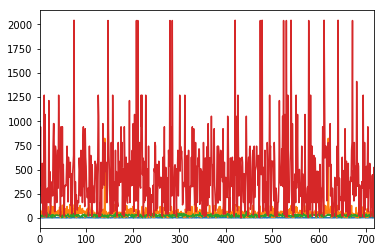

In [138]:
df["Rooms"].plot(), df["Age"].plot(),df["travel_min_to_CBD"].plot(), df["crime_C_average"].plot()

I will separate the features t see the shape and compare with the features after standardisation.

(<matplotlib.axes._subplots.AxesSubplot at 0x1986f2b1438>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1986f2b1438>)

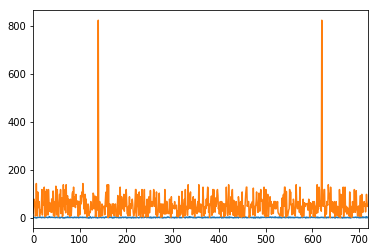

In [139]:
df["Rooms"].plot(), df["Age"].plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x1986ef1ec18>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1986ef1ec18>)

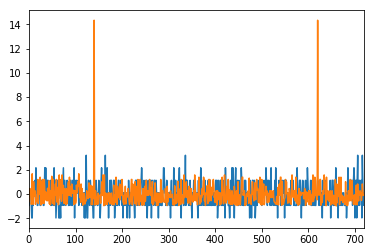

In [140]:
df["ZRooms"].plot(), df["ZAge"].plot()

We can notice that the shape of Age is same on both orignal and scaled data but shfted.

(<matplotlib.axes._subplots.AxesSubplot at 0x1987a82abe0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1987a82abe0>)

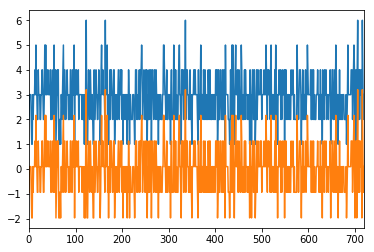

In [141]:
df["Rooms"].plot(),df["ZRooms"].plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x1987baf2b38>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1987baf2b38>)

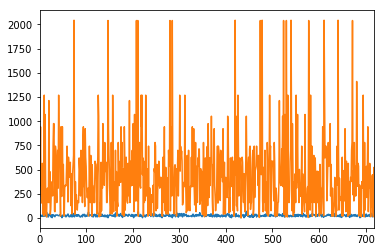

In [142]:
df["travel_min_to_CBD"].plot(), df["crime_C_average"].plot()

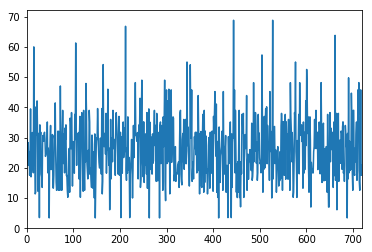

In [143]:
df["travel_min_to_CBD"].plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x19872e09f98>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19872e09f98>)

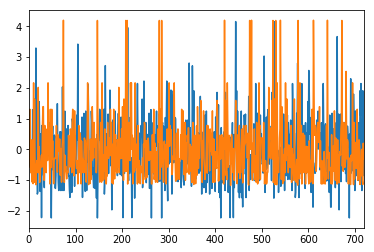

In [144]:
df["Ztravel_min_to_CBD"].plot(), df["Zcrime_C_average"].plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x19870ab35f8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19870ab35f8>)

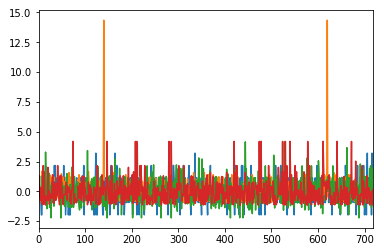

In [145]:
df["ZRooms"].plot(), df["ZAge"].plot(),df["Ztravel_min_to_CBD"].plot(), df["Zcrime_C_average"].plot()

##### 2.1.1 Plot Original and Z-score Normalse Data using Histograms

In [146]:
import matplotlib.pyplot as plt

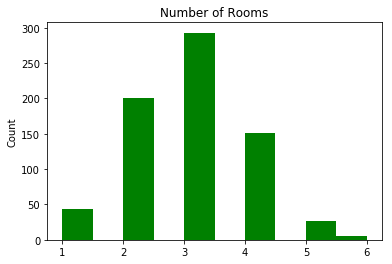

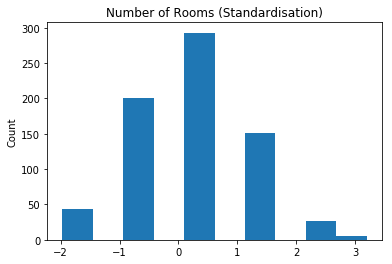

In [147]:
plt.hist(df['Rooms'], color = 'green')
plt.title('Number of Rooms')
plt.ylabel('Count')
plt.show()
plt.hist(df['ZRooms'])
plt.title('Number of Rooms (Standardisation)')
plt.ylabel('Count')
plt.show()

For Rooms there is no improvment, after Z-score normalzation the values are from -2 to 3, where  in original data is from 1 to 6. 

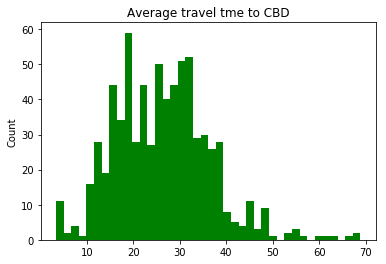

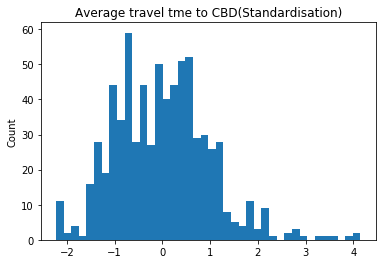

In [148]:
plt.hist(df['travel_min_to_CBD'],bins = 40, color = 'green')
plt.title('Average travel tme to CBD')
plt.ylabel('Count')
plt.show()
plt.hist(df['Ztravel_min_to_CBD'],bins = 40)
plt.title('Average travel tme to CBD(Standardisation)')
plt.ylabel('Count')
plt.show()

For travel_min_to_CBD the values are all now between -2.5 and 4.5, the shape is stll remanding same. The features are now more consistent with each other, which will allow  to evaluate the output of our future models better.

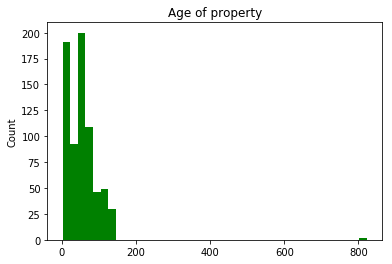

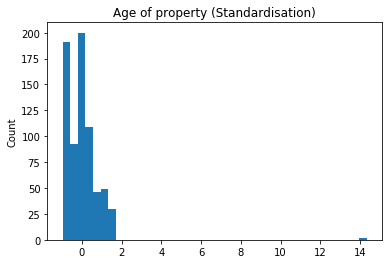

In [149]:
plt.hist(df['Age'],bins = 40, color = 'green')
plt.title('Age of property')
plt.ylabel('Count')
plt.show()
plt.hist(df['ZAge'],bins = 40)
plt.title('Age of property (Standardisation)')
plt.ylabel('Count')
plt.show()

For the Age of property we can notice in the orignal over 800 (property over 800 years). After Standardisation the values are between -1 and 14, this feature now is more consistent with the other features. 

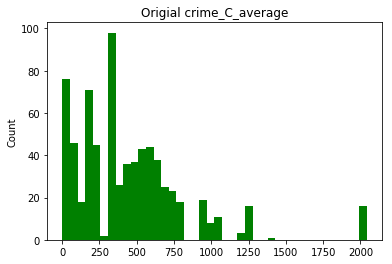

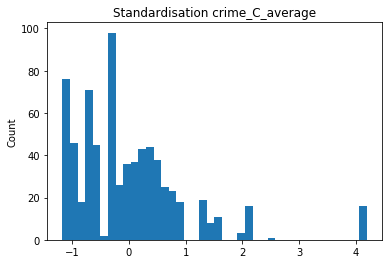

In [150]:
plt.hist(df['crime_C_average'],bins = 40, color = 'green')
plt.title('Origial crime_C_average')
plt.ylabel('Count')
plt.show()
plt.hist(df['Zcrime_C_average'],bins = 40)
plt.title('Standardisation crime_C_average')
plt.ylabel('Count')
plt.show()

For the crime_C_average we can notice in the orignal data 2000. After Standardisation the values are between -1.5 and 4.5, this feature now is more consistent with the other features.

We can see that both orignal and scaled data are in the same shape but shfted.

In [151]:
lm1 = LinearRegression()
x1 = df.loc[:,['ZRooms','ZAge','Ztravel_min_to_CBD', 'Zcrime_C_average']]
y1 = df.loc[:,'Price']

model1 = lm1.fit(x1,y1)
print( model0.coef_)
print ('r-squared for this model0 = ',model0.score(x0,y0))
print("======")
print( model1.coef_)
print ('r-squared for this model1 = ',model1.score(x1,y1))

[ 3.72597363e+05  1.22672338e+03 -1.80104689e+04  1.00195909e+02]
r-squared for this model0 =  0.37862978115757534
[ 360385.57857951   65729.15863433 -184718.33288161   38111.18261673]
r-squared for this model1 =  0.37862978115757534


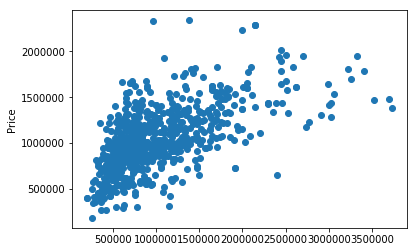

In [152]:
y_pred0 = model0.predict(x0)
plt.scatter(y0,y_pred0)
plt.ylabel('Price')
plt.show()

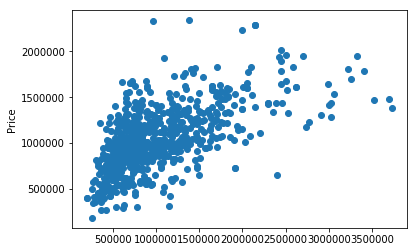

In [153]:
y_pred1 = model1.predict(x1)
plt.scatter(y1,y_pred1)
plt.ylabel('Price')
plt.show()

#### 2.2.  MinMax Noramlisation:

Min-max normalisation transforms the original range of data to a new range that is more suitable based
on the problem domain. Very common normalisation intervals are [0,1] and [-1,1]

In [154]:
minmax_scale = preprocessing.MinMaxScaler().fit(df[['Rooms','Age','travel_min_to_CBD', 'crime_C_average']])
df_minmax = minmax_scale.transform(df[['Rooms','Age','travel_min_to_CBD', 'crime_C_average']])
df_minmax[0:5]

array([[0.2       , 0.02314251, 0.26589333, 0.11120183],
       [0.4       , 0.06942753, 0.39668054, 0.23350751],
       [0.4       , 0.09378806, 0.3224593 , 0.46097322],
       [0.4       , 0.0816078 , 0.38055407, 0.16525147],
       [0.4       , 0.05724726, 0.26676694, 0.16035271]])

In [155]:
df['MMRooms'] = df_minmax[:,0] 
df['MMAge'] = df_minmax[:,1] 
df['MMtravel_min_to_CBD'] = df_minmax[:,2] 
df['MMcrime_C_average'] = df_minmax[:,3] 
df.head()

ID          Address        Suburb      Price Type        Date  \
0  ID208449822    3/3 Irving St       MALVERN   700000.0    u  27/11/2016   
1  ID769174153     23 Jacana St     CHADSTONE  1000000.0    h  27/11/2016   
2  ID189383754      101 Male St      BRIGHTON  1935000.0    h   3/06/2017   
3  ID176258151  11 Inverloch St       PRESTON  1330000.0    h  27/11/2016   
4  ID256217023    26 Collins St  WILLIAMSTOWN  1270000.0    h  19/11/2016   

   Rooms  Bathroom  Car  Landsize  ...  crime_B_average  crime_C_average  \
0      2       1.0  2.0       0.0  ...      1743.666667       228.000000   
1      3       1.0  2.0     630.0  ...      6062.333333       477.666667   
2      3       2.0  1.0     385.0  ...     11243.000000       942.000000   
3      3       2.0  3.0     502.0  ...      5219.333333       338.333333   
4      3       1.0  2.0     470.0  ...      4068.000000       328.333333   

     ZRooms      ZAge  Ztravel_min_to_CBD  Zcrime_C_average  MMRooms  \
0 -0.936241 -0.624469           -0.532582         -0.577200      0.2   
1  0.097645  0.084737            0.301535          0.079184      0.4   
2  0.097645  0.458003           -0.171823          1.299936      0.4   
3  0.097645  0.271370            0.198686         -0.287129      0.4   
4  0.097645 -0.101896           -0.527010         -0.313420      0.4   

      MMAge  MMtravel_min_to_CBD  MMcrime_C_average  
0  0.023143             0.265893           0.111202  
1  0.069428             0.396681           0.233508  
2  0.093788             0.322459           0.460973  
3  0.081608             0.380554           0.165251  
4  0.057247             0.266767           0.160353  

[5 rows x 28 columns]

In [156]:
df.describe()

Price       Rooms    Bathroom         Car      Landsize  \
count  7.200000e+02  720.000000  720.000000  720.000000    720.000000   
mean   1.038126e+06    2.905556    1.545833    1.570833    579.109722   
std    5.839227e+05    0.967898    0.725540    0.907692   2882.277951   
min    2.100000e+05    1.000000    0.000000    0.000000      0.000000   
25%    6.357500e+05    2.000000    1.000000    1.000000    157.500000   
50%    8.792500e+05    3.000000    1.000000    2.000000    431.000000   
75%    1.282500e+06    4.000000    2.000000    2.000000    646.250000   
max    3.725000e+06    6.000000    8.000000    8.000000  76000.000000   

              Age   Lattitude  Longtitude  train_station_id  \
count  720.000000  720.000000  720.000000        720.000000   
mean    54.459722  -37.809988  144.991904      20510.034722   
std     53.618324    0.077223    0.108696       3379.393729   
min      2.000000  -38.155750  144.558570      15351.000000   
25%     20.750000  -37.858400  144.923090      19922.000000   
50%     49.000000  -37.802080  144.999250      19961.000000   
75%     69.000000  -37.752390  145.053925      20014.000000   
max    823.000000  -37.568570  145.470520      52161.000000   

       distance_to_train_stat  ...  crime_B_average  crime_C_average  \
count              720.000000  ...       720.000000       720.000000   
mean              1425.728993  ...      5042.233333       447.547685   
std               1198.173391  ...      3935.636411       380.631073   
min                 47.099624  ...        68.000000         1.000000   
25%                604.773543  ...      1743.666667       161.000000   
50%               1052.343826  ...      5034.333333       368.333333   
75%               1837.310106  ...      7401.333333       586.666667   
max              12235.085559  ...     18944.000000      2042.333333   

             ZRooms          ZAge  Ztravel_min_to_CBD  Zcrime_C_average  \
count  7.200000e+02  7.200000e+02        7.200000e+02      7.200000e+02   
mean   2.721588e-17 -5.778557e-17       -8.280413e-17     -9.567964e-17   
std    1.000695e+00  1.000695e+00        1.000695e+00      1.000695e+00   
min   -1.970126e+00 -9.790718e-01       -2.228360e+00     -1.173993e+00   
25%   -9.362406e-01 -6.291348e-01       -7.730877e-01     -7.533460e-01   
50%    9.764473e-02 -1.018965e-01       -1.983433e-02     -2.082579e-01   
75%    1.131530e+00  2.713696e-01        5.411626e-01      3.657497e-01   
max    3.199301e+00  1.434350e+01        4.149303e+00      4.192759e+00   

          MMRooms       MMAge  MMtravel_min_to_CBD  MMcrime_C_average  
count  720.000000  720.000000           720.000000         720.000000  
mean     0.381111    0.063897             0.349401           0.218753  
std      0.193580    0.065309             0.156906           0.186462  
min      0.000000    0.000000             0.000000           0.000000  
25%      0.200000    0.022838             0.228183           0.078380  
50%      0.400000    0.057247             0.346291           0.179948  
75%      0.600000    0.081608             0.434254           0.286904  
max      1.000000    1.000000             1.000000           1.000000  

[8 rows x 23 columns]

The normalized value of max must be 1.0 

In [157]:
print('Min-value after min-max scaling:\nRooms = {:.2f}, Age acid = {:.2f}, travel_min_to_CBD acid = {:.2f}, crime_C_average acid = {:.2f}'
      .format(df_minmax[:,0].min(), df_minmax[:,1].min(), df_minmax[:,2].min() ,df_minmax[:,3].min()))
print('\nMax-value after min-max scaling:\nRooms = {:.2f}, Age acid = {:.2f}, travel_min_to_CBD acid = {:.2f}, crime_C_average acid = {:.2f}'
      .format(df_minmax[:,0].max(), df_minmax[:,1].max(), df_minmax[:,2].max(), df_minmax[:,3].max()))

Min-value after min-max scaling:
Rooms = 0.00, Age acid = 0.00, travel_min_to_CBD acid = 0.00, crime_C_average acid = 0.00

Max-value after min-max scaling:
Rooms = 1.00, Age acid = 1.00, travel_min_to_CBD acid = 1.00, crime_C_average acid = 1.00


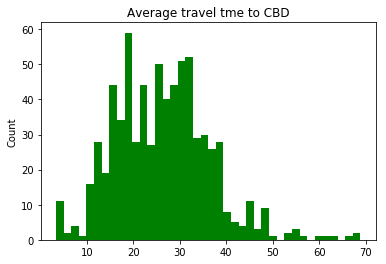

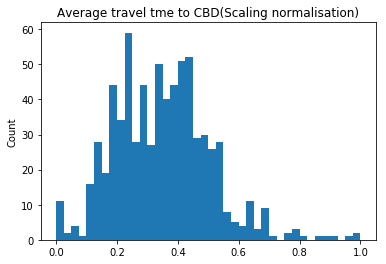

In [158]:
plt.hist(df['travel_min_to_CBD'],bins = 40, color = 'green')
plt.title('Average travel tme to CBD')
plt.ylabel('Count')
plt.show()
plt.hist(df['MMtravel_min_to_CBD'],bins = 40)
plt.title('Average travel tme to CBD(Scaling normalisation)')
plt.ylabel('Count')
plt.show()

#### 2.3. Plot standardised , normalised and orginal data values:

After normalising the data usng Z-score and min-max normalisation I will plot the <br/>

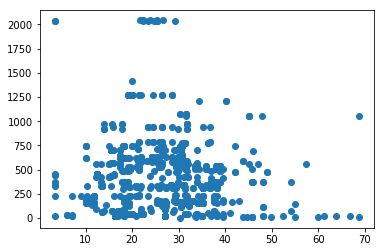

In [159]:
plt.scatter(df['travel_min_to_CBD'], df['crime_C_average'])

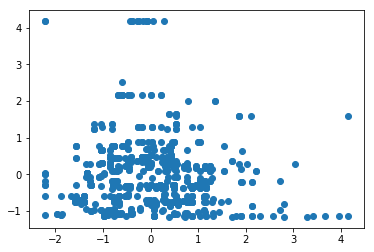

In [160]:
plt.scatter(df['Ztravel_min_to_CBD'], df['Zcrime_C_average'])

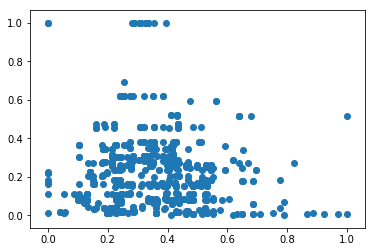

In [161]:
plt.scatter(df['MMtravel_min_to_CBD'], df['MMcrime_C_average'])

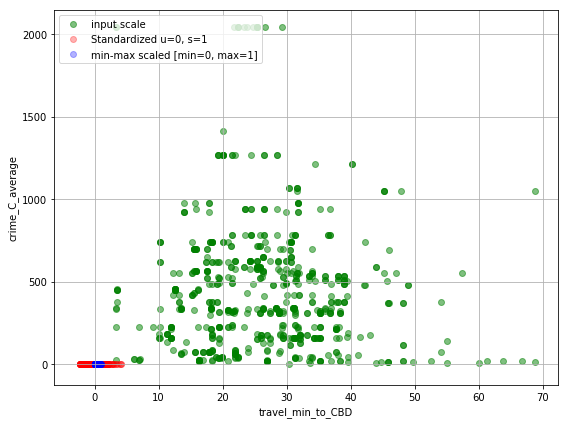

In [162]:
# and plot
%matplotlib inline

from matplotlib import pyplot as plt

def plot():
    f = plt.figure(figsize=(8,6))

    plt.scatter(df['travel_min_to_CBD'], df['crime_C_average'],
            color='green', label='input scale', alpha=0.5)

    plt.scatter(df_std[:,2], df_std[:,3], color='red',
             label='Standardized u=0, s=1', alpha=0.3) 
    
    plt.scatter(df_minmax[:,2], df_minmax[:,3],
            color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)

    plt.xlabel('travel_min_to_CBD')
    plt.ylabel('crime_C_average')
    plt.legend(loc='upper left')
    plt.grid()
    plt.tight_layout()


plot()
plt.show()

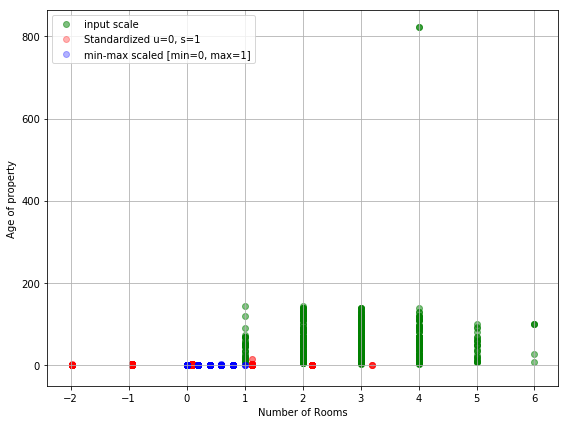

In [163]:
def plot():
    f = plt.figure(figsize=(8,6))

    plt.scatter(df['Rooms'], df['Age'],
            color='green', label='input scale', alpha=0.5)

    plt.scatter(df_std[:,0], df_std[:,1], color='red',
             label='Standardized u=0, s=1', alpha=0.3) 
    
    plt.scatter(df_minmax[:,0], df_minmax[:,1],
            color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)

    plt.xlabel('Number of Rooms')
    plt.ylabel('Age of property')
    plt.legend(loc='upper left')
    plt.grid()
    plt.tight_layout()

plot()
plt.show()

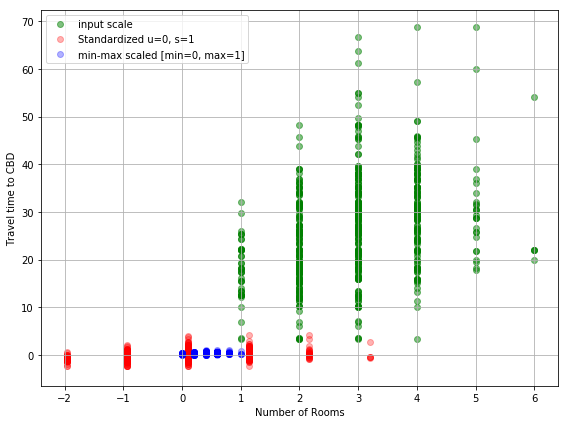

In [164]:
def plot():
    f = plt.figure(figsize=(8,6))

    plt.scatter(df['Rooms'], df['travel_min_to_CBD'],
            color='green', label='input scale', alpha=0.5)

    plt.scatter(df_std[:,0], df_std[:,2], color='red',
             label='Standardized u=0, s=1', alpha=0.3) 
    
    plt.scatter(df_minmax[:,0], df_minmax[:,2],
            color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)

    plt.xlabel('Number of Rooms')
    plt.ylabel('Travel time to CBD')
    plt.legend(loc='upper left')
    plt.grid()
    plt.tight_layout()

plot()
plt.show()

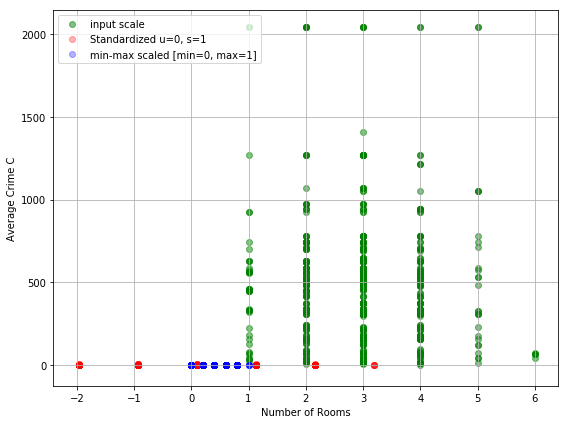

In [165]:
def plot():
    f = plt.figure(figsize=(8,6))

    plt.scatter(df['Rooms'], df['crime_C_average'],
            color='green', label='input scale', alpha=0.5)

    plt.scatter(df_std[:,0], df_std[:,3], color='red',
             label='Standardized u=0, s=1', alpha=0.3) 
    
    plt.scatter(df_minmax[:,0], df_minmax[:,3],
            color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)

    plt.xlabel('Number of Rooms')
    plt.ylabel('Average Crime C')
    plt.legend(loc='upper left')
    plt.grid()
    plt.tight_layout()

plot()
plt.show()

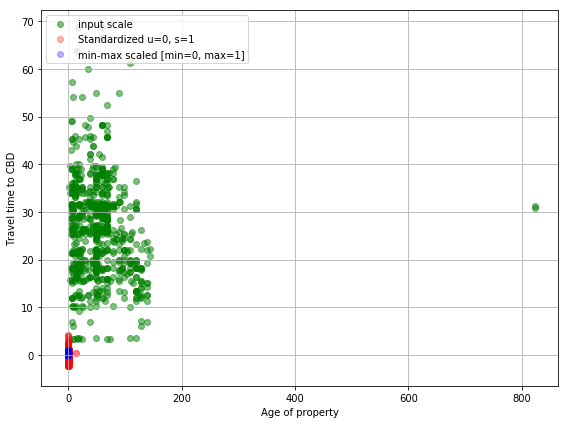

In [166]:
def plot():
    f = plt.figure(figsize=(8,6))

    plt.scatter(df['Age'], df['travel_min_to_CBD'],
            color='green', label='input scale', alpha=0.5)

    plt.scatter(df_std[:,1], df_std[:,2], color='red',
             label='Standardized u=0, s=1', alpha=0.3) 
    
    plt.scatter(df_minmax[:,1], df_minmax[:,2],
            color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)

    plt.xlabel('Age of property')
    plt.ylabel('Travel time to CBD')
    plt.legend(loc='upper left')
    plt.grid()
    plt.tight_layout()


plot()
plt.show()

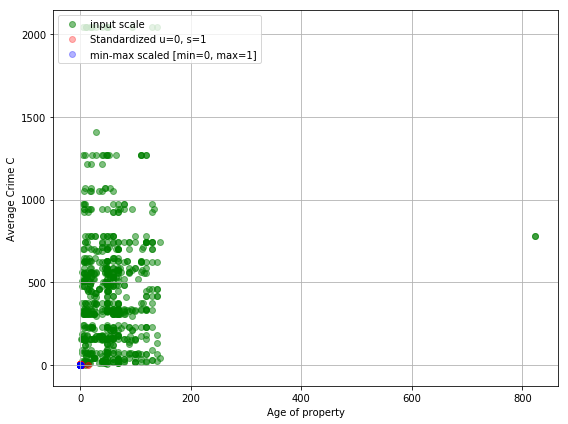

In [167]:
def plot():
    f = plt.figure(figsize=(8,6))

    plt.scatter(df['Age'], df['crime_C_average'],
            color='green', label='input scale', alpha=0.5)

    plt.scatter(df_std[:,1], df_std[:,3], color='red',
             label='Standardized u=0, s=1', alpha=0.3) 
    
    plt.scatter(df_minmax[:,1], df_minmax[:,3],
            color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)

    plt.xlabel('Age of property')
    plt.ylabel('Average Crime C')
    plt.legend(loc='upper left')
    plt.grid()
    plt.tight_layout()
    

plot()
plt.show()

In [168]:
df.head()

ID          Address        Suburb      Price Type        Date  \
0  ID208449822    3/3 Irving St       MALVERN   700000.0    u  27/11/2016   
1  ID769174153     23 Jacana St     CHADSTONE  1000000.0    h  27/11/2016   
2  ID189383754      101 Male St      BRIGHTON  1935000.0    h   3/06/2017   
3  ID176258151  11 Inverloch St       PRESTON  1330000.0    h  27/11/2016   
4  ID256217023    26 Collins St  WILLIAMSTOWN  1270000.0    h  19/11/2016   

   Rooms  Bathroom  Car  Landsize  ...  crime_B_average  crime_C_average  \
0      2       1.0  2.0       0.0  ...      1743.666667       228.000000   
1      3       1.0  2.0     630.0  ...      6062.333333       477.666667   
2      3       2.0  1.0     385.0  ...     11243.000000       942.000000   
3      3       2.0  3.0     502.0  ...      5219.333333       338.333333   
4      3       1.0  2.0     470.0  ...      4068.000000       328.333333   

     ZRooms      ZAge  Ztravel_min_to_CBD  Zcrime_C_average  MMRooms  \
0 -0.936241 -0.624469           -0.532582         -0.577200      0.2   
1  0.097645  0.084737            0.301535          0.079184      0.4   
2  0.097645  0.458003           -0.171823          1.299936      0.4   
3  0.097645  0.271370            0.198686         -0.287129      0.4   
4  0.097645 -0.101896           -0.527010         -0.313420      0.4   

      MMAge  MMtravel_min_to_CBD  MMcrime_C_average  
0  0.023143             0.265893           0.111202  
1  0.069428             0.396681           0.233508  
2  0.093788             0.322459           0.460973  
3  0.081608             0.380554           0.165251  
4  0.057247             0.266767           0.160353  

[5 rows x 28 columns]

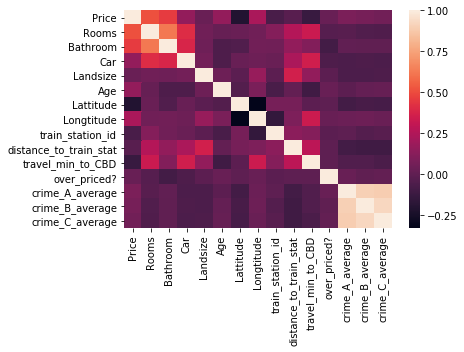

In [172]:
import seaborn as sns
#corr = df.loc[:,['Rooms','Age','travel_min_to_CBD', 'crime_C_average', 'Price']].corr() columnNames
corr = df.loc[:,columnNames].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [174]:
columnNames =list(df.columns.values)
print(columnNames)

['ID', 'Address', 'Suburb', 'Price', 'Type', 'Date', 'Rooms', 'Bathroom', 'Car', 'Landsize', 'Age', 'Lattitude', 'Longtitude', 'train_station_id', 'distance_to_train_stat', 'travel_min_to_CBD', 'over_priced?', 'crime_A_average', 'crime_B_average', 'crime_C_average', 'ZRooms', 'ZAge', 'Ztravel_min_to_CBD', 'Zcrime_C_average', 'MMRooms', 'MMAge', 'MMtravel_min_to_CBD', 'MMcrime_C_average']


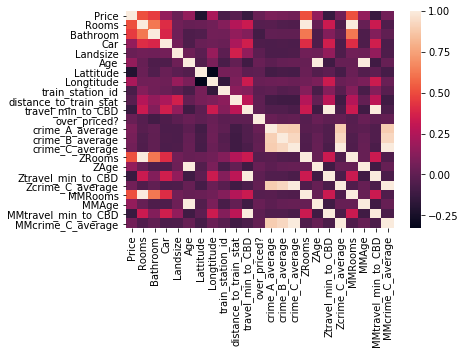

In [175]:
corr = df.loc[:,columnNames].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)